# Predicting Urban Heat Islands

##### Packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install rioxarray
!pip install rasterio
!pip install stackstac
!pip install pystac_client
!pip install planetary_computer
!pip install odc.stac
!pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.7/207.7 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.1/155.1 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.3 MB/s eta 0:00:00


In [ ]:
# Machine Learning
from sklearn.ensemble import RandomForestRegressor

# Model Saving
import joblib

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Import Data Science Packages
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import common GIS tools
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio
from matplotlib.cm import RdYlGn,jet,RdBu

# Geospatial raster data handling
import rioxarray as rxr

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

# Others
import os
from tqdm import tqdm

# ckdTree for mapping
from scipy.spatial import cKDTree

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Import Planetary Computer tools
import stackstac
import pystac_client
import planetary_computer
from odc.stac import stac_load


# set the number of columns we see
pd.set_option('display.max_columns',None)

# Functions

In [ ]:
# create a function that can collect satellite data
def create_xarray_data(location, date_range, satellite, cloud_coverage, bands, resolution):
    """
    Fetch Sentinel-2 imagery as an xarray dataset.

    Parameters:
    - location: Tuple (min_lon, min_lat, max_lon, max_lat) defining the bounding box.
    - date_range: String in 'YYYY-MM-DD/YYYY-MM-DD' format defining the time window.
    - satellite: Name of the satellite collection (e.g., 'sentinel-2-l2a').
    - cloud_coverage: Max cloud cover percentage (integer, e.g., 30 for <30% clouds).
    - bands: List of band names (e.g., ['B02', 'B03', 'B04'] for RGB).
    - resolution: Desired spatial resolution in meters (e.g., 10m for Sentinel-2).

    Returns:
    - xarray.Dataset containing the requested satellite data.
    """

    # Define bounding box
    # Connect to Microsoft Planetary Computer STAC API
    stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")


    # Search for matching satellite imagery
    search = stac.search(
        bbox=location,
        datetime=date_range,
        collections=[satellite],
        query={"eo:cloud_cover": {"lt": cloud_coverage}},
    )

    # Convert search results to a list
    items = list(search.get_items())
    print(f'Satellite Images Found: {len(items)}')

    if not items:
        raise ValueError("No STAC items found for the given parameters.")

    # Sign the items for access
    signed_items = [planetary_computer.sign(item) for item in items]

    # Load data using stackstac
    data = stac_load(
        signed_items,
        bands=bands,
        crs="EPSG:4326",  # Latitude-Longitude
        resolution=resolution / 111320.0,  # Ensure resolution is in meters
        chunks={"x": 2048, "y": 2048},  # Optimize chunking
        dtype="uint16",
        patch_url=planetary_computer.sign,
        bbox=location
    )

    return data

In [ ]:
def sentinel_1_xarray(location,date_range,satellite,bands):
    # Step 1: Connect to the Planetary Computer STAC API
    catalog_url = "https://planetarycomputer.microsoft.com/api/stac/v1"
    catalog = pystac_client.Client.open(catalog_url)

    # Step 2: Define your search parameters
    time_range = "2021-07-26/2021-07-26"  # Up to current date, July 26th 2021

    search = catalog.search(
        collections=[satellite],  # Sentinel-1 GRD product
        bbox=location,
        datetime=date_range,
        limit=10
    )

    # Step 3: Retrieve the items
    items = list(search.items())
    print(f"Found {len(items)} Sentinel-1 scenes.")

    signed_items = [planetary_computer.sign(item).to_dict() for item in items]

        # Define the pixel resolution for the final product
    # Define the scale according to our selected crs, so we will use degrees
    resolution = 10  # meters per pixel
    scale = resolution / 111320.0 # degrees per pixel for crs=4326

    # 'items' is a list of STAC Items from a prior search (e.g., via pystac_client)
    sentinel_1_july_26th = stac_load(
        items,                           # STAC Items from Sentinel-1 GRD search
        bands=bands,             # Sentinel-1 polarization bands
        crs="EPSG:4326",                # Latitude-Longitude coordinate system
        resolution=scale,               # Degrees (set 'scale' to desired resolution, e.g., 0.0001 for ~10 m)
        chunks={"x": 2048, "y": 2048},  # Dask chunks for lazy loading
        dtype="uint16",                 # GRD data typically uint16 (check metadata if float32 needed)
        patch_url=planetary_computer.sign,  # Sign URLs for Planetary Computer access
        bbox=location                     # Bounding box in EPSG:4326 [min_lon, min_lat, max_lon, max_lat]
    )

    return sentinel_1_july_26th

In [ ]:
import os

def output_file(filename, image_data, bounds, bands, location):
    """
    Saves a multi-band raster (GeoTIFF) from an xarray dataset.

    Parameters:
    - filename (str): Name of the output file (e.g., "output.tif").
    - image_data (xarray.DataArray or xarray.Dataset): The dataset containing band data.
    - bounds (tuple): Bounding box (min_lon, min_lat, max_lon, max_lat).
    - bands (list): List of band names to include in the output file.

    Returns:
    - None (Saves the GeoTIFF file)
    """

    filename = os.path.join(location, filename)

    # Extract width and height from dataset dimensions
    height = image_data.dims["latitude"]
    width = image_data.dims["longitude"]

    # Create raster transform using bounding box
    gt = rasterio.transform.from_bounds(bounds[0], bounds[1], bounds[2], bounds[3], width, height)

    # Assign CRS and transform to the dataset
    image_data.rio.write_crs("epsg:4326", inplace=True)
    image_data.rio.write_transform(transform=gt, inplace=True)

    # Create GeoTIFF output file
    with rasterio.open(filename, 'w', driver='GTiff', width=width, height=height,
                       crs='epsg:4326', transform=gt, count=len(bands),
                       compress='lzw', dtype='float64') as dst:
        for i, band in enumerate(bands):
            dst.write(image_data[band].values, i + 1)  # Ensure NumPy array format

    print(f"GeoTIFF saved: {filename}")

In [ ]:
# function to create a median mosaic
def median_mosaic(data):
    median = data.median(dim='time').compute()
    return median

In [ ]:
def create_lidar_data(satellite,location,date_range):
    client = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1/",
    )

    search = client.search(
        collections=[satellite],
        bbox=location,
        datetime=date_range
    )

    # Retrieve items
    items = {x.collection_id: x for x in search.get_all_items()}

    # Print available collection IDs for debugging
    print("Available collection IDs:", items.keys())

    item = items[satellite]

    asset_key = 'data'

    signed_url = planetary_computer.sign(item.assets[asset_key].href)

    file = rxr.open_rasterio(signed_url)

    return file

In [ ]:
from rasterio.transform import from_bounds

def lidar_file(filename, image_data, bounds, location):
    """
    Saves a single-band raster (GeoTIFF) from an xarray dataset.

    Parameters:
    - filename (str): Name of the output file (e.g., "output.tif").
    - image_data (xarray.DataArray): The dataset containing raster data.
    - bounds (tuple): Bounding box (min_lon, min_lat, max_lon, max_lat).
    - location (str): Directory where the file will be saved.

    Returns:
    - None (Saves the GeoTIFF file)
    """

    filename = os.path.join(location, filename)

    # Extract width and height from dataset dimensions
    time, height, width = image_data.shape  # (4097, 4097)

    # Create raster transform using bounding box
    transform = from_bounds(bounds[0], bounds[1], bounds[2], bounds[3], width, height)

    # Assign CRS and transform to the dataset
    image_data.rio.write_crs("epsg:4326", inplace=True)
    image_data.rio.write_transform(transform, inplace=True)

    # Save the dataset as a GeoTIFF
    with rasterio.open(filename, 'w', driver='GTiff', width=width, height=height,
                       count=1, crs='epsg:4326', transform=transform, dtype='float32',
                       compress='lzw') as dst:
        dst.write(image_data.values.squeeze(), 1)  # Write the single band

    print(f"GeoTIFF saved: {filename}")

In [ ]:
def map_satellite_data(tiff_path,training_data, band_names):
    # Load the GeoTIFF data
    data = rxr.open_rasterio(tiff_path)
    tiff_crs = data.rio.crs

    # Read the CSV file
    latitudes = training_data['Latitude'].values
    longitudes = training_data['Longitude'].values

    # Convert lat/long to the GeoTIFF's CRS
    proj_wgs84 = Proj(init='epsg:4326')
    proj_tiff = Proj(tiff_crs)
    transformer = Transformer.from_proj(proj_wgs84, proj_tiff)

    # Reproject coordinates
    transformed_coords = [transformer.transform(lat, lon) for lat, lon in zip(latitudes, longitudes)]
    xs, ys = zip(*transformed_coords)

    # Get available band numbers
    band_numbers = data.coords["band"].values

    # Validate that the user provided the correct number of band names
    if len(band_names) != len(band_numbers):
        raise ValueError(f"Expected {len(band_numbers)} band names, but got {len(band_names)}")

    # Dictionary to store extracted band values
    band_data = {band_name: [] for band_name in band_names}

    # Extract values for each band
    for x, y in tqdm(zip(xs, ys), total=len(xs), desc="Extracting band values"):
        for band, band_name in zip(band_numbers, band_names):
            value = data.sel(x=x, y=y, band=band, method="nearest").values
            band_data[band_name].append(value)

    # Convert dictionary to DataFrame
    return pd.DataFrame(band_data)

In [ ]:
# Combine two datasets vertically (along columns) using pandas concat function.
def combine_two_datasets(dataset1,dataset2):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined
    dataset2 - Dataset 2 to be combined
    '''

    data = pd.concat([dataset1,dataset2], axis=1)
    return data

In [ ]:
def add_nearest_data(uhi_data: pd.DataFrame, data_to_map: pd.DataFrame) -> pd.DataFrame:
    """
    Adds the nearest elevation value to the UHI dataset using a KDTree for fast nearest-neighbor search.

    Parameters:
        uhi_data (pd.DataFrame): DataFrame containing UHI data with 'Latitude' and 'Longitude' columns.
        elevation_data (pd.DataFrame): DataFrame containing elevation data with 'Latitude', 'Longitude', and 'z_grade' columns.

    Returns:
        pd.DataFrame: UHI dataset with an added 'Elevation' column.
    """
    # Extract coordinates from both datasets
    elevation_coords = np.array(list(zip(data_to_map["Latitude"], data_to_map["Longitude"])))
    uhi_coords = np.array(list(zip(uhi_data["Latitude"], uhi_data["Longitude"])))

    # Build KDTree for fast nearest-neighbor search
    tree = cKDTree(elevation_coords)

    # Find the nearest elevation point for each UHI point
    distances, indices = tree.query(uhi_coords)

    # Add the matched elevation values to the UHI dataset
    uhi_data = uhi_data.copy()

    for col in data_to_map.drop(columns=['Longitude','Latitude']):
        uhi_data[col] = data_to_map.iloc[indices][col].values

    return uhi_data

In [ ]:
def create_rounded_data(data):

    # convert the data to float values
    data = data.astype(float)

    # round by 3 decimal places
    data[['Longitude','Latitude']] = data[['Longitude','Latitude']].round(3)

    # group by the similar long/lat
    data = data.groupby(['Longitude','Latitude']).median().reset_index()

    return data

# Model Building
We are going to use the NYC urban heat island temperatures to train the model.

## NYC Model Building

### Load Data

In [ ]:
# load in the uhi train data to be used as the training data
uhi_train = pd.read_csv('/content/drive/MyDrive/NASA SPACEAPPS 2025/Training_data_uhi_index_2025-02-18.csv')

uhi_train

,Longitude,Latitude,datetime,UHI Index
0,-73.909167,40.813107,24-07-2021 15:53,1.030289
1,-73.909187,40.813045,24-07-2021 15:53,1.030289
2,-73.909215,40.812978,24-07-2021 15:53,1.023798
3,-73.909242,40.812908,24-07-2021 15:53,1.023798
4,-73.909257,40.812845,24-07-2021 15:53,1.021634
...,...,...,...,...
11224,-73.957050,40.790333,24-07-2021 15:57,0.972470
11225,-73.957063,40.790308,24-07-2021 15:57,0.972470
11226,-73.957093,40.790270,24-07-2021 15:57,0.981124
11227,-73.957112,40.790253,24-07-2021 15:59,0.981245


In [ ]:
nyc_location = (-74.00, 40.75, -73.87, 40.86)

### Satellite Imagery Creation

#### Sentinel 2 Satellite Data
- Location - NYC
- Time Window - Summer 2021
- Satellite - Sentinel 2
- Cloud Coverage - <30%
- Bands - ("B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12")

Sentinel 2 satellite is a polar orbiting satellite and has a 5 day revisit time which allows time series data to be collect of the Earth. We are going to collect a series of images from the summer of 2021 to identify statistically average band values, this is done by taking a median mosaic.

In [ ]:
nyc_location = (-74.00, 40.75, -73.87, 40.86) # Bounding box for NYC
summer_2021 = "2021-06-01/2021-09-01"         # Summer 2021
satellite = "sentinel-2-l2a"                  # Sentinel-2 Level 2A
cloud_coverage = 30                           # Max 30% cloud cover
sentinel_2_bands = ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"] # Sentinel 2 Bands
resolution = 10 # Resolution of 10m

summer_sentinel_2_xarray = create_xarray_data(nyc_location,summer_2021,satellite,cloud_coverage,sentinel_2_bands,resolution)

Satellite Images Found: 10


Using Microsoft planetary computer we are able to fetch an xarray data format where we have 10 dates of sentinel 2 band data in the proximity of NYC. These values can now be changed for any location on the Earth to identify Urban Heat Islands.

In [ ]:
# now lets created a median mosaic
# this is done to remove clouds which may impact the sentinel 2 values
# known as statistically removing clouds
summer_sentinel_2 = median_mosaic(summer_sentinel_2_xarray)

In [ ]:
output_file('sentinel_2_summer.tiff',summer_sentinel_2,nyc_location,summer_sentinel_2,'/content/drive/MyDrive/NASA SPACEAPPS 2025')

GeoTIFF saved: /content/drive/MyDrive/NASA SPACEAPPS 2025/sentinel_2_summer.tiff


After statistically removing the clouds we created a tiff file which can be used later in this notebook to load in satellite imagery data.

#### Sentinel 1 Data
- Location - NYC
- Time Window - July 26th 2021
- Satellite - Sentinel 1
- Cloud Coverage - 10
- Sentinel 1 - (vv,vh)
- Resolution - 30

The sentinel 1 satellite is a part of the European Union Copernicus and is another satellite which is useful in tracking climate changes across the globe. We are going to be interested in two of their bands VV and VH which are used to capture bare soil in imagery.

In [ ]:
nyc_location = (-74.00, 40.75, -73.87, 40.86) # Bounding box for NYC
sentinel_1_date = '2021-06-01/2021-09-01'     # Sentinel 1 date
sentinel_1 = "sentinel-1-grd"                 # Sentinel-1 GRD
low_cloud_coverage = 0                        # Max 10% cloud cover
sentinel_1_all_bands = ['vv','vh']            # Sentinel 1 bands
resolution = 10                               # 10m resolution

sentinel_1_summer_xarray = sentinel_1_xarray(nyc_location,sentinel_1_date,sentinel_1,sentinel_1_all_bands)

Found 7 Sentinel-1 scenes.


We are going to be using another median mosaic for the summer of 2021.

In [ ]:
sentinel_1_summer = median_mosaic(sentinel_1_summer_xarray)

In [ ]:
output_file('sentinel_1_summer.tiff',sentinel_1_summer,nyc_location,sentinel_1_all_bands,'/content/drive/MyDrive/NASA SPACEAPPS 2025')

GeoTIFF saved: /content/drive/MyDrive/NASA SPACEAPPS 2025/sentinel_1_summer.tiff


#### Landsat Data
- Location - NYC
- Time Window - Summer 2021
- Satellite - Landsat 8
- Cloud Coverage - 30
- Bands - (lwir11,red,green,blue,nir08)
- Resolution - 30

The landsat 8 satellite is a sun-synchronous near polar orbit and specialzes in thermal infrared sennsors and operational land imager.

###### Thermal
We are going to be using May 15th as the thermal data as the temperature most closely matched with the temperature on July 24th which was the day of the training (there was no thermal data for July 24th)

In [ ]:
nyc_location = (-74.00, 40.75, -73.87, 40.86)  # Bounding box for NYC
landsat_date = "2021-05-15/2021-05-15"         # Landsat date - closest temperature to test data
landsat = "landsat-c2-l2"                      # Landsat 8 Satellite
cloud_coverage = 30                            # Max 30% cloud cover
thermal_bands = ["lwir11"]                     # landsat bands
resolution = 10                                # 10m resolution

landsat_thermal_05_may_xarray = create_xarray_data(nyc_location,landsat_date,landsat,cloud_coverage,thermal_bands,resolution)

Satellite Images Found: 1


In [ ]:
landsat_thermal_05_may = median_mosaic(landsat_thermal_05_may_xarray)

In [ ]:
# Scale Factors for the Surface Temperature band
scale2 = 0.00341802
offset2 = 149.0
kelvin_celsius = 273.15 # convert from Kelvin to Celsius
landsat_thermal_05_may = landsat_thermal_05_may.astype(float) * scale2 + offset2 - kelvin_celsius

The above scaling is done to turn the lwir11 values into temperature in degrees celsius, this showed strong improvements in this satellite data in model creation.

In [ ]:
output_file('landsat_thermal_05_may.tiff',landsat_thermal_05_may,nyc_location,thermal_bands,'/content/drive/MyDrive/NASA SPACEAPPS 2025')

GeoTIFF saved: /content/drive/MyDrive/NASA SPACEAPPS 2025/landsat_thermal_05_may.tiff


##### Non Thermal Bands

In [ ]:
nyc_location = (-74.00, 40.75, -73.87, 40.86)  # Bounding box for NYC
landsat_summer_date = "2021-06-01/2021-09-01"  # Landsat Summer Date
landsat = "landsat-c2-l2"                      # Landsat 8 Satellite
cloud_coverage = 30                            # Max 30% cloud cover
non_thermal_bands = ['red','blue','green','nir08'] # landsat bands
resolution = 10

landsat_non_thermal_summer_xarray = create_xarray_data(nyc_location,landsat_summer_date,landsat,cloud_coverage,non_thermal_bands,resolution)

Satellite Images Found: 13


In [ ]:
landsat_non_thermal_summer = median_mosaic(landsat_non_thermal_summer_xarray)

In [ ]:
# Scale Factors for the RGB and NIR bands
scale1 = 0.0000275
offset1 = -0.2
landsat_non_thermal_summer[['red','blue','green','nir08']] = landsat_non_thermal_summer[['red','blue','green','nir08']].astype(float) * scale1 + offset1

Further scaling done for the other band values.

In [ ]:
output_file('landsat_non_thermal_summer.tiff', landsat_non_thermal_summer, nyc_location, non_thermal_bands,'/content/drive/MyDrive/NASA SPACEAPPS 2025')

GeoTIFF saved: /content/drive/MyDrive/NASA SPACEAPPS 2025/landsat_non_thermal_summer.tiff


### Lidar Elevation
- DSM: Total Elevation
- DTM: Natural Elevation
- HAG: Building Height Only

#### DSM: Total Elevation

In [ ]:
nyc_dsm_elevation = create_lidar_data('3dep-lidar-dsm',nyc_location,'2010-01-01/2024-01-01')

Available collection IDs: dict_keys(['3dep-lidar-dsm'])


In [ ]:
lidar_file('lidar_elevation_dsm_nyc.tiff',nyc_dsm_elevation,nyc_location,'/content/drive/MyDrive/NASA SPACEAPPS 2025')

GeoTIFF saved: /content/drive/MyDrive/NASA SPACEAPPS 2025/lidar_elevation_dsm_nyc.tiff


#### DTM: Natural Elevation

In [ ]:
nyc_dtm_natural_elevation = create_lidar_data('3dep-lidar-dtm',nyc_location,'2010-01-01/2024-01-01')

Available collection IDs: dict_keys(['3dep-lidar-dtm'])


In [ ]:
lidar_file('lidar_elevation_dtm_nyc.tiff',nyc_dtm_natural_elevation,nyc_location,'/content/drive/MyDrive/NASA SPACEAPPS 2025')

GeoTIFF saved: /content/drive/MyDrive/NASA SPACEAPPS 2025/lidar_elevation_dtm_nyc.tiff


#### HAG: Building Height Only

In [ ]:
nyc_hag_building_elevation = create_lidar_data('3dep-lidar-hag',nyc_location,'2010-01-01/2024-01-01')

Available collection IDs: dict_keys(['3dep-lidar-hag'])


In [ ]:
lidar_file('lidar_elevation_hag_nyc.tiff',nyc_hag_building_elevation,nyc_location,'/content/drive/MyDrive/NASA SPACEAPPS 2025')

GeoTIFF saved: /content/drive/MyDrive/NASA SPACEAPPS 2025/lidar_elevation_hag_nyc.tiff


### Create Noise
We are going to add 5 points of noise around data with a standard deviation of 0.0001 for each long/lat value, this will allow us to generalize values to reduce outliers impacting model.

In [ ]:
# let's create a funciton that creates random noise for a single point

def generate_noise(long,lat,proximity_points,std=0.0001):
    lat_noisy = lat + np.random.normal(0,std,proximity_points)
    long_noisy = long + np.random.normal(0,std,proximity_points)

    return list(zip(long_noisy, lat_noisy))

In [ ]:
sentinel_long_noisy = []
sentinel_lat_noisy = []

for _,row in uhi_train.iterrows():
    long = row['Longitude']
    lat = row['Latitude']

    noise = generate_noise(long,lat,5)
    for i,row in enumerate(noise):
        sentinel_long_noisy.append(noise[i][0])
        sentinel_lat_noisy.append(noise[i][1])


# create a new df
proximity_uhi_train = pd.DataFrame({'Longitude':sentinel_long_noisy,'Latitude':sentinel_lat_noisy})

proximity_uhi_train

,Longitude,Latitude
0,-73.909200,40.813042
1,-73.909240,40.813245
2,-73.909149,40.813321
3,-73.909222,40.813100
4,-73.909193,40.813092
...,...,...
56140,-73.957089,40.790278
56141,-73.957230,40.790170
56142,-73.957089,40.790358
56143,-73.957130,40.790043


### Satellite Imagery Loading
Using proximity elevation is going to be achieved using a grid-like manipulation of values. We are going to round our data to three decimal places and then get the median value of all of the points with the same long/lat values, this essentially creates a spatial proximity rather than a granular one.
As we load in satellite data, we want to perform this activity to use a proximity to get values of data to use.
However, when we are working with **11229(?)** training data points, it is not enough to create proximity data which is accurate so we are going to artifically create noise in the creation of satellite data.

1. Add random noise to the training long/lat points
2. Map the band values to the noisy long/lat
3. Round the long/lat to 3 places
4. Group by the long/lat
5. Get the median of those with similar long/lat
6. Now we have about 1500 median data points
7. Map training long/lat to the 1500 median data points (nearest point)
8. Map the test long/lat to the 1500 data points (nearest point)

When we have this data we can map whatever training data we have to the nearest proximity data point to get the most generalized version of a data point.

#### Sentinel 2

In [ ]:
# load the data in
sentinel_2_summer_data = map_satellite_data('/content/drive/MyDrive/NASA SPACEAPPS 2025/sentinel_2_summer.tiff', proximity_uhi_train, sentinel_2_bands)

sentinel_2_summer_data

Extracting band values: 100%|██████████| 56145/56145 [16:12<00:00, 57.73it/s]


,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12
0,841.5,1053.0,1155.0,1206.0,1481.5,1660.5,1721.0,1832.0,1709.0,1792.0,1495.5
1,1154.5,1412.0,1512.0,1847.0,1885.0,1966.0,1965.5,1986.0,2006.5,2183.5,2040.0
2,1154.5,1391.0,1523.0,1715.0,1747.0,1822.5,1848.5,1849.0,1878.0,2100.0,1906.0
3,841.5,1053.0,1155.0,1206.0,1481.5,1660.5,1721.0,1832.0,1709.0,1792.0,1495.5
4,841.5,1053.0,1155.0,1206.0,1481.5,1660.5,1721.0,1832.0,1709.0,1792.0,1495.5
...,...,...,...,...,...,...,...,...,...,...,...
56140,462.5,506.5,741.5,551.5,999.0,2612.0,3111.5,3572.0,3446.5,1925.0,1072.5
56141,462.5,557.5,804.5,645.0,954.5,2708.0,3229.0,3529.0,3301.0,1916.5,1120.0
56142,462.5,491.0,725.5,501.0,999.0,2612.0,3111.5,3152.0,3446.5,1925.0,1072.5
56143,462.5,825.0,926.5,884.5,1119.5,2308.0,2888.5,2102.0,3006.5,2002.5,1215.0


In [ ]:
# combine long/lat
sentinel_2_proximity_data = combine_two_datasets(proximity_uhi_train,sentinel_2_summer_data)

sentinel_2_proximity_data = create_rounded_data(sentinel_2_proximity_data)

In [ ]:
sentinel_2_proximity_data.to_csv('/content/drive/MyDrive/NASA SPACEAPPS 2025/sentinel_2_proximity_data.csv')

In [ ]:
nyc_sentinel_2_proximity_data = pd.read_csv('/content/drive/MyDrive/NASA SPACEAPPS 2025/sentinel_2_proximity_data.csv',index_col=0)

nyc_sentinel_2_proximity_data

,Longitude,Latitude,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12
0,-73.995,40.771,1112.0,1861.00,2007.0,2226.0,1991.00,1993.5,2096.5,2261.0,2077.5,2048.0,1881.0
1,-73.995,40.772,1112.0,1418.00,1595.0,1721.5,1680.00,1720.0,1744.0,1765.5,1741.5,1841.0,1732.5
2,-73.994,40.771,1112.0,1619.00,1798.0,1851.0,2034.50,2061.0,2040.0,1947.0,2036.0,2145.0,2106.5
3,-73.994,40.772,1275.0,1423.00,1554.0,1674.0,1772.00,1817.0,1858.0,1725.0,1792.5,1904.5,1762.0
4,-73.994,40.773,1275.0,1225.50,1379.5,1465.5,1810.50,1766.5,1870.5,1753.0,1852.5,1921.0,1701.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1505,-73.880,40.809,1202.5,1456.00,1589.0,1764.0,1946.00,1993.5,1954.0,1858.0,1955.0,2135.5,1963.5
1506,-73.880,40.810,1271.0,1102.75,1186.0,1269.0,1236.50,1473.5,1614.5,1792.0,1693.0,1524.0,1421.5
1507,-73.879,40.805,956.0,693.00,968.5,844.5,1340.00,1946.5,2168.0,2683.0,2187.5,1669.0,1382.5
1508,-73.879,40.806,956.0,1087.00,1168.0,1212.0,1283.25,1532.5,1608.0,1390.0,1615.5,1679.0,1428.0


In [ ]:
nyc_sentinel_2_proximity_uhi_train = add_nearest_data(uhi_train,nyc_sentinel_2_proximity_data)

nyc_sentinel_2_proximity_uhi_train

,Longitude,Latitude,datetime,UHI Index,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,841.5,685.50,825.75,841.0,1212.0,1883.0,2079.75,2036.0,2218.5,1617.5,1305.5
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,841.5,685.50,825.75,841.0,1212.0,1883.0,2079.75,2036.0,2218.5,1617.5,1305.5
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,841.5,685.50,825.75,841.0,1212.0,1883.0,2079.75,2036.0,2218.5,1617.5,1305.5
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,841.5,685.50,825.75,841.0,1212.0,1883.0,2079.75,2036.0,2218.5,1617.5,1305.5
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,841.5,685.50,825.75,841.0,1212.0,1883.0,2079.75,2036.0,2218.5,1617.5,1305.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11224,-73.957050,40.790333,24-07-2021 15:57,0.972470,462.5,508.75,741.50,551.5,999.0,2612.0,3111.50,3226.5,3446.5,1925.0,1072.5
11225,-73.957063,40.790308,24-07-2021 15:57,0.972470,462.5,508.75,741.50,551.5,999.0,2612.0,3111.50,3226.5,3446.5,1925.0,1072.5
11226,-73.957093,40.790270,24-07-2021 15:57,0.981124,462.5,508.75,741.50,551.5,999.0,2612.0,3111.50,3226.5,3446.5,1925.0,1072.5
11227,-73.957112,40.790253,24-07-2021 15:59,0.981245,462.5,508.75,741.50,551.5,999.0,2612.0,3111.50,3226.5,3446.5,1925.0,1072.5


#### Sentinel 1

In [ ]:
sentinel_1_summer_proximity = map_satellite_data('/content/drive/MyDrive/NASA SPACEAPPS 2025/sentinel_1_summer.tiff', proximity_uhi_train, sentinel_1_all_bands)

Extracting band values: 100%|██████████| 56145/56145 [02:45<00:00, 340.12it/s]


In [ ]:
# combine long/lat
sentinel_1_proximity_data = combine_two_datasets(proximity_uhi_train, sentinel_1_summer_proximity)

sentinel_1_proximity_data = create_rounded_data(sentinel_1_proximity_data)

sentinel_1_proximity_data.to_csv('/content/drive/MyDrive/NASA SPACEAPPS 2025/sentinel_1_proximity_data.csv')

In [ ]:
nyc_sentinel_1_proximity_data = pd.read_csv('/content/drive/MyDrive/NASA SPACEAPPS 2025/sentinel_1_proximity_data.csv', index_col=0)

nyc_sentinel_1_proximity_uhi_train = add_nearest_data(uhi_train,nyc_sentinel_1_proximity_data)

nyc_sentinel_1_proximity_uhi_train

,Longitude,Latitude,datetime,UHI Index,vv,vh
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,329.0,189.5
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,329.0,189.5
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,329.0,189.5
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,329.0,189.5
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,329.0,189.5
...,...,...,...,...,...,...
11224,-73.957050,40.790333,24-07-2021 15:57,0.972470,214.0,106.0
11225,-73.957063,40.790308,24-07-2021 15:57,0.972470,214.0,106.0
11226,-73.957093,40.790270,24-07-2021 15:57,0.981124,214.0,106.0
11227,-73.957112,40.790253,24-07-2021 15:59,0.981245,214.0,106.0


#### Landsat Thermal

In [ ]:
landsat_thermal_05_may_granular = map_satellite_data('/content/drive/MyDrive/NASA SPACEAPPS 2025/landsat_thermal_05_may.tiff',uhi_train,thermal_bands)

Extracting band values: 100%|██████████| 11229/11229 [00:16<00:00, 662.14it/s]


In [ ]:
# combine long/lat
landsat_thermal_data = combine_two_datasets(uhi_train, landsat_thermal_05_may_granular)

landsat_thermal_data

,Longitude,Latitude,datetime,UHI Index,lwir11
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,37.09167548000005
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,37.09167548000005
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,37.09167548000005
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,37.09167548000005
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,36.760127539999985
...,...,...,...,...,...
11224,-73.957050,40.790333,24-07-2021 15:57,0.972470,29.951431700000057
11225,-73.957063,40.790308,24-07-2021 15:57,0.972470,30.03346418000001
11226,-73.957093,40.790270,24-07-2021 15:57,0.981124,30.03346418000001
11227,-73.957112,40.790253,24-07-2021 15:59,0.981245,30.03346418000001


In [ ]:
landsat_thermal_data.to_csv('/content/drive/MyDrive/NASA SPACEAPPS 2025/landsat_8_granular_data.csv')

In [ ]:
nyc_landsat_thermal = pd.read_csv('/content/drive/MyDrive/NASA SPACEAPPS 2025/landsat_8_granular_data.csv',index_col=0)

nyc_landsat_thermal

,Longitude,Latitude,datetime,UHI Index,lwir11
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,37.091675
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,37.091675
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,37.091675
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,37.091675
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,36.760128
...,...,...,...,...,...
11224,-73.957050,40.790333,24-07-2021 15:57,0.972470,29.951432
11225,-73.957063,40.790308,24-07-2021 15:57,0.972470,30.033464
11226,-73.957093,40.790270,24-07-2021 15:57,0.981124,30.033464
11227,-73.957112,40.790253,24-07-2021 15:59,0.981245,30.033464


#### Landsat non thermal

In [ ]:
landsat_non_thermal_summer_granular = map_satellite_data('/content/drive/MyDrive/NASA SPACEAPPS 2025/landsat_non_thermal_summer.tiff',proximity_uhi_train,non_thermal_bands)

Extracting band values: 100%|██████████| 56145/56145 [05:28<00:00, 170.73it/s]


In [ ]:
# combine long/lat
landsat_non_thermal_data = combine_two_datasets(proximity_uhi_train, landsat_non_thermal_summer_granular)

landsat_non_thermal_proximity = create_rounded_data(landsat_non_thermal_data)

landsat_non_thermal_data.head()

,Longitude,Latitude,red,blue,green,nir08
0,-73.909200,40.813042,0.07016,0.05407250000000002,0.073515,0.19182
1,-73.909240,40.813245,0.12370249999999999,0.091775,0.1111625,0.19578
2,-73.909149,40.813321,0.12370249999999999,0.091775,0.1111625,0.19578
3,-73.909222,40.813100,0.07016,0.05407250000000002,0.073515,0.19182
4,-73.909193,40.813092,0.07016,0.05407250000000002,0.073515,0.19182


In [ ]:
landsat_non_thermal_proximity.to_csv('/content/drive/MyDrive/NASA SPACEAPPS 2025/landsat_8_non_thermal_proximity_data.csv')

In [ ]:
nyc_landsat_non_thermal = pd.read_csv('/content/drive/MyDrive/NASA SPACEAPPS 2025/landsat_8_non_thermal_proximity_data.csv',index_col=0)

nyc_landsat_non_thermal_uhi_train = add_nearest_data(uhi_train, nyc_landsat_non_thermal)

nyc_landsat_non_thermal_uhi_train

,Longitude,Latitude,datetime,UHI Index,red,blue,green,nir08
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,0.089685,0.070380,0.089712,0.202669
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,0.089685,0.070380,0.089712,0.202669
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,0.089685,0.070380,0.089712,0.202669
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,0.089685,0.070380,0.089712,0.202669
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,0.089685,0.070380,0.089712,0.202669
...,...,...,...,...,...,...,...,...
11224,-73.957050,40.790333,24-07-2021 15:57,0.972470,0.049480,0.046345,0.065238,0.320987
11225,-73.957063,40.790308,24-07-2021 15:57,0.972470,0.049480,0.046345,0.065238,0.320987
11226,-73.957093,40.790270,24-07-2021 15:57,0.981124,0.049480,0.046345,0.065238,0.320987
11227,-73.957112,40.790253,24-07-2021 15:59,0.981245,0.049480,0.046345,0.065238,0.320987


#### DSM Lidar Elevation: Total Elevation

In [ ]:
nyc_dsm_elevation = map_satellite_data('/content/drive/MyDrive/NASA SPACEAPPS 2025/lidar_elevation_dsm_nyc.tiff',proximity_uhi_train,['dsm_elevation'])

Extracting band values: 100%|██████████| 56145/56145 [01:22<00:00, 677.09it/s]


In [ ]:
nyc_dsm_elevation = combine_two_datasets(proximity_uhi_train,nyc_dsm_elevation)

nyc_dsm_elevation = nyc_dsm_elevation[nyc_dsm_elevation['dsm_elevation'] > 0]

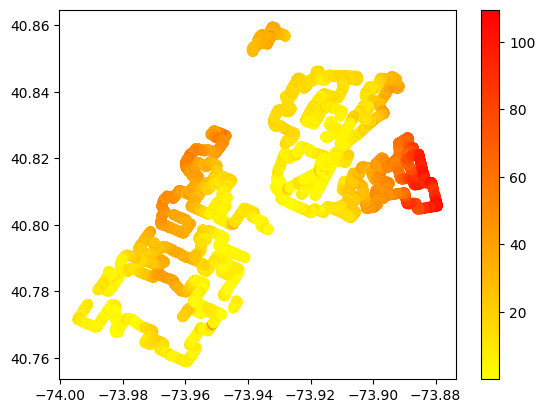

In [ ]:
plt.scatter(nyc_dsm_elevation['Longitude'],nyc_dsm_elevation['Latitude'],c=nyc_dsm_elevation['dsm_elevation'],cmap='autumn_r')
plt.colorbar()

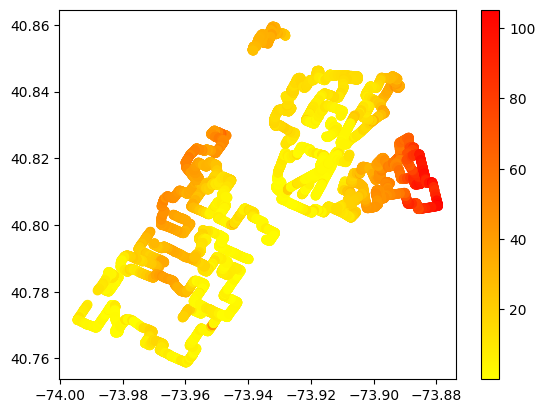

In [ ]:
nyc_dsm_elevation_uhi_train = add_nearest_data(uhi_train,create_rounded_data(nyc_dsm_elevation))

plt.scatter(nyc_dsm_elevation_uhi_train['Longitude'],nyc_dsm_elevation_uhi_train['Latitude'],c=nyc_dsm_elevation_uhi_train['dsm_elevation'],cmap='autumn_r')
plt.colorbar()

##### DTM Lidar Elevation: Natural Elevation

In [ ]:
nyc_dtm_elevation = map_satellite_data('/content/drive/MyDrive/NASA SPACEAPPS 2025/lidar_elevation_dtm_nyc.tiff',proximity_uhi_train,['dtm_elevation'])

Extracting band values: 100%|██████████| 56145/56145 [01:23<00:00, 670.77it/s]


In [ ]:
nyc_dtm_elevation = combine_two_datasets(proximity_uhi_train,nyc_dtm_elevation)

nyc_dtm_elevation = nyc_dtm_elevation[nyc_dtm_elevation['dtm_elevation'] > 0]

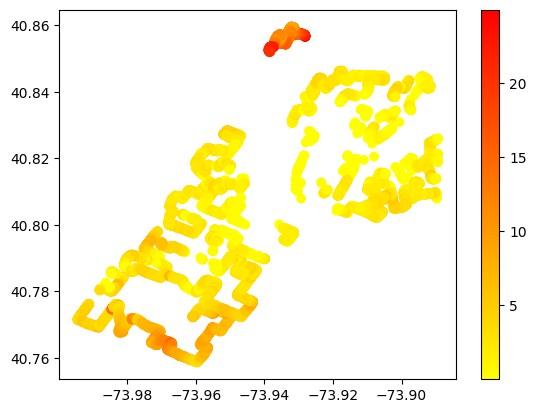

In [ ]:
plt.scatter(nyc_dtm_elevation['Longitude'],nyc_dtm_elevation['Latitude'],c=nyc_dtm_elevation['dtm_elevation'],cmap='autumn_r')
plt.colorbar()

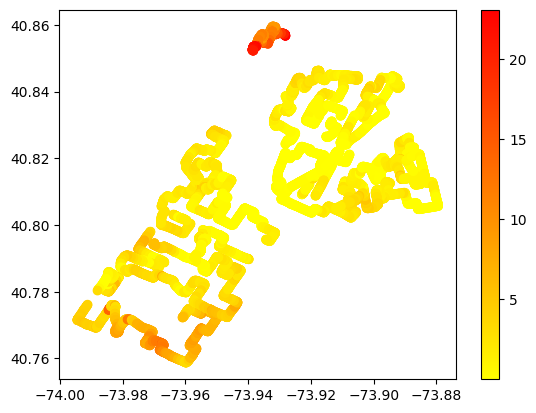

In [ ]:
nyc_dtm_elevation_uhi_train = add_nearest_data(uhi_train,create_rounded_data(nyc_dtm_elevation))

plt.scatter(nyc_dtm_elevation_uhi_train['Longitude'],nyc_dtm_elevation_uhi_train['Latitude'],c=nyc_dtm_elevation_uhi_train['dtm_elevation'],cmap='autumn_r')
plt.colorbar()

##### Hag Lidar Elevation: uilding Height Only

In [ ]:
nyc_hag_elevation = map_satellite_data('/content/drive/MyDrive/NASA SPACEAPPS 2025/lidar_elevation_hag_nyc.tiff',proximity_uhi_train,['hag_elevation'])

Extracting band values: 100%|██████████| 56145/56145 [01:21<00:00, 688.62it/s]


In [ ]:
nyc_hag_elevation = combine_two_datasets(proximity_uhi_train,nyc_hag_elevation)

nyc_hag_elevation = nyc_hag_elevation[nyc_hag_elevation['hag_elevation'] > 0]

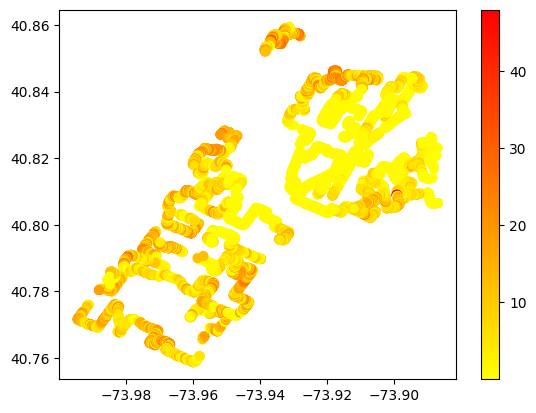

In [ ]:
plt.scatter(nyc_hag_elevation['Longitude'],nyc_hag_elevation['Latitude'],c=nyc_hag_elevation['hag_elevation'],cmap='autumn_r')
plt.colorbar()

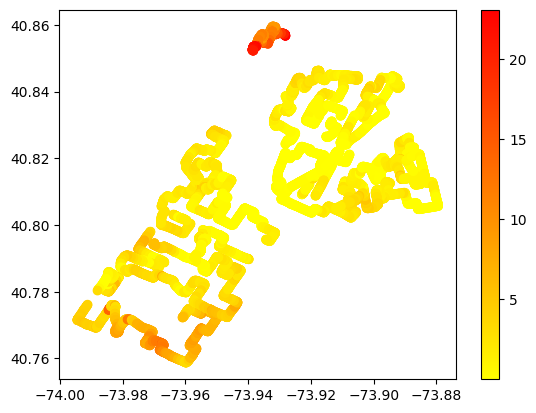

In [ ]:
nyc_hag_elevation_uhi_train = add_nearest_data(uhi_train,create_rounded_data(nyc_hag_elevation))

plt.scatter(nyc_hag_elevation_uhi_train['Longitude'],nyc_hag_elevation_uhi_train['Latitude'],c=nyc_dtm_elevation_uhi_train['dtm_elevation'],cmap='autumn_r')
plt.colorbar()

## Build NYC Model
- Sentinel 2
- Sentinel 1
- Landsat Thermal
- Landsat Non Thermal
- Lidar dsm
- Lidar dtm
- Lidar HAG

In [ ]:
nyc_X = pd.DataFrame()

nyc_X[sentinel_2_bands] = nyc_sentinel_2_proximity_uhi_train[sentinel_2_bands]
nyc_X[sentinel_1_all_bands] = nyc_sentinel_1_proximity_uhi_train[sentinel_1_all_bands]
nyc_X[thermal_bands] = nyc_landsat_thermal[thermal_bands]
nyc_X[non_thermal_bands] = nyc_landsat_non_thermal_uhi_train[non_thermal_bands]
nyc_X['dsm elevation'] = nyc_dsm_elevation_uhi_train['dsm_elevation']
nyc_X['dtm elevation'] = nyc_dtm_elevation_uhi_train['dtm_elevation']
nyc_X['hag elevation'] = nyc_hag_elevation_uhi_train['hag_elevation']

In [ ]:
nyc_X

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,vv,vh,lwir11,red,blue,green,nir08,dsm elevation,dtm elevation,hag elevation
0,841.5,685.50,825.75,841.0,1212.0,1883.0,2079.75,2036.0,2218.5,1617.5,1305.5,329.0,189.5,37.091675,0.089685,0.070380,0.089712,0.202669,8.721918,1.570656,1.86
1,841.5,685.50,825.75,841.0,1212.0,1883.0,2079.75,2036.0,2218.5,1617.5,1305.5,329.0,189.5,37.091675,0.089685,0.070380,0.089712,0.202669,8.721918,1.570656,1.86
2,841.5,685.50,825.75,841.0,1212.0,1883.0,2079.75,2036.0,2218.5,1617.5,1305.5,329.0,189.5,37.091675,0.089685,0.070380,0.089712,0.202669,8.721918,1.570656,1.86
3,841.5,685.50,825.75,841.0,1212.0,1883.0,2079.75,2036.0,2218.5,1617.5,1305.5,329.0,189.5,37.091675,0.089685,0.070380,0.089712,0.202669,8.721918,1.570656,1.86
4,841.5,685.50,825.75,841.0,1212.0,1883.0,2079.75,2036.0,2218.5,1617.5,1305.5,329.0,189.5,36.760128,0.089685,0.070380,0.089712,0.202669,8.721918,1.570656,1.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11224,462.5,508.75,741.50,551.5,999.0,2612.0,3111.50,3226.5,3446.5,1925.0,1072.5,214.0,106.0,29.951432,0.049480,0.046345,0.065238,0.320987,25.188410,1.023763,12.26
11225,462.5,508.75,741.50,551.5,999.0,2612.0,3111.50,3226.5,3446.5,1925.0,1072.5,214.0,106.0,30.033464,0.049480,0.046345,0.065238,0.320987,25.188410,1.023763,12.26
11226,462.5,508.75,741.50,551.5,999.0,2612.0,3111.50,3226.5,3446.5,1925.0,1072.5,214.0,106.0,30.033464,0.049480,0.046345,0.065238,0.320987,25.188410,1.023763,12.26
11227,462.5,508.75,741.50,551.5,999.0,2612.0,3111.50,3226.5,3446.5,1925.0,1072.5,214.0,106.0,30.033464,0.049480,0.046345,0.065238,0.320987,25.188410,1.023763,12.26


In [ ]:
y = uhi_train['UHI Index']

In [ ]:
X_tr,X_ts,y_tr,y_ts = train_test_split(nyc_X,y)

In [ ]:
rf = RandomForestRegressor().fit(X_tr,y_tr)

rf.score(X_ts,y_ts)

0.9399486307063615

In [ ]:
# Save the trained RandomForestRegressor model

joblib.dump(rf, "/content/drive/MyDrive/NASA SPACEAPPS 2025/model/rf_model_joblib.md")

['/content/drive/MyDrive/NASA SPACEAPPS 2025/model/rf_model_joblib.md']

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 [Text(0, 0, 'B01'),
  Text(1, 0, 'B02'),
  Text(2, 0, 'B03'),
  Text(3, 0, 'B04'),
  Text(4, 0, 'B05'),
  Text(5, 0, 'B06'),
  Text(6, 0, 'B07'),
  Text(7, 0, 'B08'),
  Text(8, 0, 'B8A'),
  Text(9, 0, 'B11'),
  Text(10, 0, 'B12'),
  Text(11, 0, 'vv'),
  Text(12, 0, 'vh'),
  Text(13, 0, 'lwir11'),
  Text(14, 0, 'red'),
  Text(15, 0, 'blue'),
  Text(16, 0, 'green'),
  Text(17, 0, 'nir08'),
  Text(18, 0, 'dsm elevation'),
  Text(19, 0, 'dtm elevation'),
  Text(20, 0, 'hag elevation')])

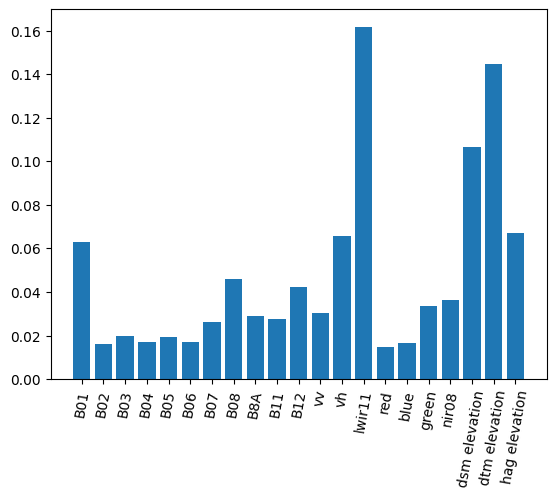

In [ ]:
plt.bar(nyc_X.columns, rf.feature_importances_)
plt.xticks(rotation=80)

We now have a model - we can predict uhi values of user's selected location.